# Make a FS2 Euclid RR2 catalog/map

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import LSS_forward_model
from LSS_forward_model.cosmology import *
from LSS_forward_model.lensing import *
from LSS_forward_model.maps import *
from LSS_forward_model.halos import *
from LSS_forward_model.tsz import *
from LSS_forward_model.theory import *
import os
import pandas as pd
import numpy as np
import healpy as hp
from cosmology import Cosmology
import astropy.io.fits as fits
import copy
import glass
import frogress
from astropy.cosmology import wCDM
import astropy
import cosmolopy.distance as cd
import scipy

# Setup forward model - config

In [2]:
# Setup     ********************************
path_simulation = '/global/cfs/cdirs/m5099/FS2/'
# general settings ----------------------------------
nside_maps = 1024

# nuisance parameters ------------------------------
nuisance_parameters = dict()
nuisance_parameters['dz'] =  [0,0,0,0,0,0,0]
nuisance_parameters['dm'] =  [1,1,1,1,1,1,1]
nuisance_parameters['A_IA'] = 0.
nuisance_parameters['eta_IA'] = 0.
nuisance_parameters['bias_sc'] = [1,1,1,1,1,1,1]
nuisance_parameters['rot'] = 0


# Baryonification settings ------------------------------------------------
baryons = {
    "enabled": False,
    "max_z_halo_catalog": 1.5,
    "mass_cut": 13,
    "do_tSZ": False,
    "base_params_path": "../Data/Baryonification_wl_tsz_flamingo_parameters.npy",
    "filename_new_params": "sys_baryo_0.npy",
    "values_to_update":  None, # or: {'Mc': 10**13,'theta_ej' : 4.} or draw_params_from_specs( {"M_c": (12.5, 15.5, "log10"),   "theta_ej": (3.0, 10.0, "lin"),    "eta": (-2.0, -0.1, "log10")} )
}

SC_corrections = np.load('../Data/SC_RR2_fit_nov6.npy',allow_pickle =True).item()

# Read cosmology & setup params

In [3]:

# FS3 Cosmology ****************************************
sims_parameters = {'Omega_b': 0.04900000000000004,
 'Omega_nu': 0.00142963544897283,
 'Omega_r': 5.508989439238772e-05,
 'Omega_m': 0.31899999999997314,
 'Omega_cdm': 0.26857036455100025,
 'h': 0.6699998481005214,
 'w0': -1.0,
 'wa': 0.0,
 'As': 2.1e-09,
 'n_s': 0.96,
 'sigma_8': 0.8153419356755818,
 'm_nu': 0.05977381159918407,
  'n_nu': 3}


cosmo_bundle = make_cosmo_bundle(sims_parameters)

sims_parameters.update(nuisance_parameters)

# baryons - 
bpar, sys = load_or_save_updated_params(path_simulation,baryons['base_params_path'],baryons['filename_new_params'],baryons['values_to_update'], overwrite = False)
sims_parameters.update(sys)


df = pd.read_csv(path_simulation+"steps.fs2.ssv", delim_whitespace=True)
comoving_edges = np.hstack([np.array(df['dist_min']),np.array(df['dist_max'])[-1]])/sims_parameters['h'] 

z_edges = distance_to_redshit(comoving_edges,cosmo_bundle)
shells_info = make_shells_info_from_edges(z_edges, comoving_edges)


/tmp/ipykernel_2049260/3226952851.py:26: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(path_simulation+"steps.fs2.ssv", delim_whitespace=True)


# setup n(z)

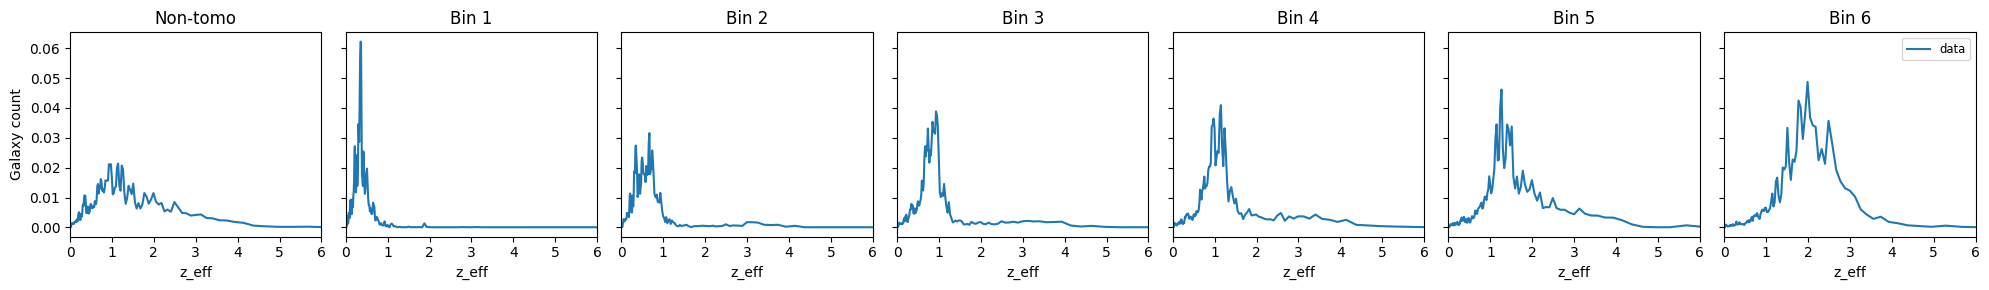

In [4]:
nz_RR2 = np.load('/global/cfs/cdirs/m5099/RR2/Reg2_SHE_tombins_unitweights_nz_SOMbin_C2020z_rebinned.npy',allow_pickle=True).item()

# -------------------------------------------------------
nz_shifted, shells, steps, zeff_glass, ngal_glass = apply_nz_shifts_and_build_shells(
    z_rebinned=nz_RR2['z_rebinned'],
    nz_all=nz_RR2['nz_rebinned'],
    dz_values=sims_parameters["dz"],
    shells_info=shells_info,
)

# Plot -----------------------------------------------------------------
fig, axes = plt.subplots(1, 7, figsize=(20, 3), sharey=True)
titles = ["Non-tomo"] + [f"Bin {i}" for i in range(1, 7)]
for i, ax in enumerate(axes):
    ax.plot(zeff_glass, ngal_glass[i], label="data")
    ax.set_xlim(0, 6)
    ax.set_title(titles[i])
    if i == 0: ax.set_ylabel("Galaxy count")
    ax.set_xlabel("z_eff")
axes[-1].legend(loc="upper right", fontsize="small")
plt.tight_layout(); plt.show()


# load density shells and compute shear field

In [5]:
density = []
for i in frogress.bar(range(200)):
    ii = 200-i
    formatted_path = path_simulation + 'counts_{0}_{1}.npy'.format(ii,nside_maps)
    m = np.load(formatted_path,allow_pickle=True)
    delta_ = m/np.mean(m)-1
    density.append(delta_) 


# shear field ---------------------------
fields = compute_lensing_fields(density, shells, cosmo_bundle['pars_camb'], nside_maps, do_kappa=True, do_shear=True, do_IA=True)
fields['density'] = density

100.0% | [##########] | Progress: 200 / 200 | Time: 2min49s | ETA: --          

# Theory checks

EuclidEmulator2 emulates the non-linear correction in 
the interval [8.73e-3 h/Mpc, 9.41h/Mpc]. You are 
requesting k modes beyond k_max = 9.41h/Mpc. 
Higher k modes constantly extrapolated.
EuclidEmulator2 emulates the non-linear correction in 
the interval [8.73e-3 h/Mpc, 9.41h/Mpc]. You are 
requesting k modes below k_min = 8.73e-3 h/Mpc. 
Lower k modes constantly extrapolated.
100.0% | [##########] | Progress: 4000 / 4000 | Time: 6.3s | ETA: --           

/tmp/ipykernel_2049260/3912409165.py:22: RuntimeWarning: divide by zero encountered in divide
  ax.plot(Cls[tomo, :ell_max]/(Cgg[tomo, tomo, :ell_max] * (pix**2)))


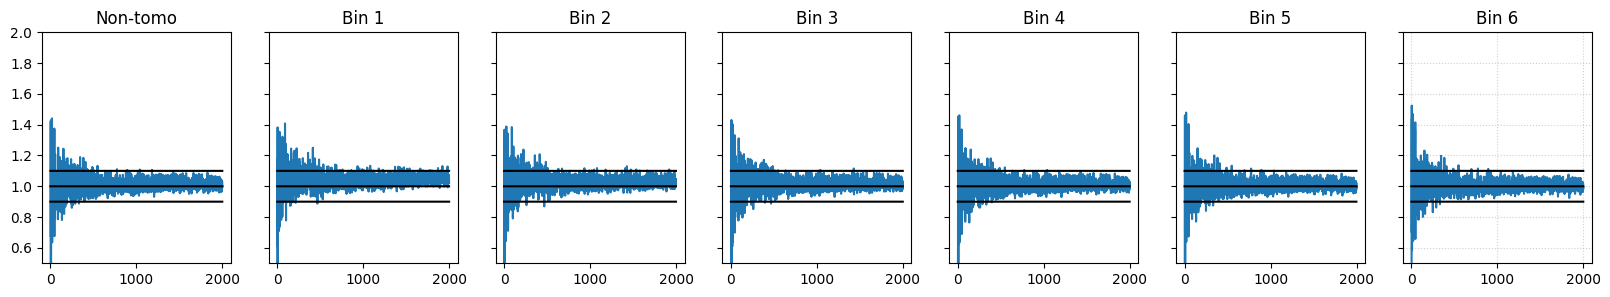

In [6]:
theory = LimberTheory(cosmo_bundle['pars_camb'], lmax=4000, nonlinear="euclidemu")  # "euclidemu" | "mead" | "halofit"
theory.set_Wshear(np.vstack([nz_RR2['z_rebinned'],nz_shifted]).T)
Cgg = theory.cl_gg(nonlinear=True)


kappa_tomo = integrate_field(ngal_glass, fields["kappa"])

Cls = np.array([(hp.anafast(kappa_tomo[tomo,:])) for tomo in range(len(ngal_glass))])



# choose a safe ℓ-range common to all arrays
ell_max = 2000
pix = hp.pixwin(nside_maps)[:ell_max]
ells = np.arange(ell_max)

mask_ell = ells >= 2  # avoid ℓ=0,1

fig, axes = plt.subplots(1, 7, figsize=(20, 3), sharey=True)
titles = ["Non-tomo"] + [f"Bin {i}" for i in range(1, 7)]
for tomo, ax in enumerate(axes):
    ax.plot(Cls[tomo, :ell_max]/(Cgg[tomo, tomo, :ell_max] * (pix**2)))
    ax.plot(np.ones(ell_max),color = 'black')
    ax.plot(0.9*np.ones(ell_max),color = 'black')
    ax.plot(1.1*np.ones(ell_max),color = 'black')
    ax.set_ylim([0.5,2])
    ax.set_title(titles[tomo])

ax.grid(True, which="both", ls=":", alpha=0.6)


# Make mocks/maps

In [7]:
path_data_cats = '/global/cfs/cdirs/m5099/RR2/Euclid_cats.npy'
cats_Euclid  = np.load(path_data_cats,allow_pickle=True).item()
maps_Gower_WL,_ = make_WL_sample(ngal_glass, zeff_glass, cosmo_bundle, sims_parameters, nside_maps, fields, cats_Euclid, SC_corrections = SC_corrections, do_catalog = False, include_SC = True)

#  process counts from FS2 nto lower nside

In [ ]:
import astropy.io.fits as fits
import healpy as hp
import numpy as np

for i in range(0,201):
    ##try:
    #    path_simulation = '/pscratch/sd/m/mgatti/Flagship/'
    #    m = fits.open('/pscratch/sd/m/mgatti/Flagship/wl{0}.nest.fits'.format(i))
    #    nside_big = 8192
    #    c_ring = hp.reorder(m[1].data['dmcounts'], n2r=True)   
    #    
    #    nside_small = 1024
    #    c_downgraded = hp.alm2map(hp.map2alm(c_ring,lmax = 2*nside_small),nside = nside_small,pixwin=True)*nside_big**2/nside_small**2
    #    np.save(path_simulation + 'counts_{0}_{1}.npy'.format(i,nside_small),c_downgraded)
    #
    #    nside_small = 4096
    #    c_downgraded = hp.alm2map(hp.map2alm(c_ring,lmax = 2*nside_small),nside = nside_small,pixwin=True)*nside_big**2/nside_small**2
    #    np.save(path_simulation + 'counts_{0}_{1}.npy'.format(i,nside_small),c_downgraded)
    #    print ('done ',i)
    #except:
    #    pass